# COMP24112 Summative Exercise (30 Marks)
# On Linear Classification and MLP Regression

In this lab exercise, you will build linear classifiers by gradient descent for loan approval classification (14 marks) and build MLP regressors for crop production prediction (16 marks), using two given datasets. To prepare for this lab exercise, you will
* Get familiar with lecture content of Chapters 3-7.
* Get familiar with how to build a regression model by mutlilayer perceptron (MLP) using the scikit learn tutorial (https://scikit-learn.org/stable/modules/neural_networks_supervised.html#regression).
* Get familiar with basic scikit-learn tools for [data splitting](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html), used for setting machine learning experiments.


You will submit a notebook file, a pdf report, and a trained model. You will be marked for implementation, design, result and analysis. Your code should be easy to read and your report should be concise (max 600 words). It is strongly recommended that you use a LaTeX editor, such as [Overleaf](https://www.overleaf.com/), to write your report. Handwritten reports will not be accepted.

Please note your notebook should take no more than 10 minutes to run on a Google Colab instance. **Marks may be dropped for inefficient and unreadable code.**


## 1. Linear Loan Classification (14 marks)
### 1.1 Dataset and Experiment Preparation

**On Dataset**: The provided "Loan Approval Classification Dataset" contains financial and demographic information related to loan applications. It includes 45,000 instances with 14 features, covering applicant demographics, credit history, and loan details, with a mix of categorical (e.g., gender, education, etc) and numerical features (e.g., age, income, etc). You will predict the loan_status variable, which indicates whether a loan application was approved (1) or rejected (0).

**On Data Pre-processing**: This dataset contains categorical featuers which are encoded as text. For our models to interpret these features, it is necessary to preprocess this dataset &mdash; in this case, convert categorical features into one-hot encoding &mdash; by using tools from pandas (https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html). Example code is provided below. 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
import sklearn.model_selection

notebook_start_time = time.time()
loan_data_full = pd.read_csv("loan_data.csv")

# Display a sample of the original dataset, which includes both categorical and numerical features
loan_data_full.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [2]:
# Generate and display summary statistics of the dataset to check key attributes such as sample count, mean, and standard deviation of numerical features
loan_data_full.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In [3]:
# Data preprocessing: Convert categorical features into one-hot encoded format
# The categorical features being encoded include: person_gender, person_education, person_home_ownership, loan_intent, and previous_loan_defaults_on_file
loan_data = pd.get_dummies(loan_data_full, columns=['person_home_ownership', 'loan_intent', 'person_education', 'previous_loan_defaults_on_file', 'person_gender'])
# Remove redundant columns to avoid multicollinearity
loan_data = loan_data.drop(columns=['person_gender_male', 'previous_loan_defaults_on_file_No'])

# Display a sample of the dataset after preprocessing
loan_data.head()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_home_ownership_MORTGAGE,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,person_education_Associate,person_education_Bachelor,person_education_Doctorate,person_education_High School,person_education_Master,previous_loan_defaults_on_file_Yes,person_gender_female
0,22.0,71948.0,0,35000.0,16.02,0.49,3.0,561,1,False,...,False,True,False,False,False,False,False,True,False,True
1,21.0,12282.0,0,1000.0,11.14,0.08,2.0,504,0,False,...,False,False,False,False,False,False,True,False,True,True
2,25.0,12438.0,3,5500.0,12.87,0.44,3.0,635,1,True,...,True,False,False,False,False,False,True,False,False,True
3,23.0,79753.0,0,35000.0,15.23,0.44,2.0,675,1,False,...,True,False,False,False,True,False,False,False,False,True
4,24.0,66135.0,1,35000.0,14.27,0.53,4.0,586,1,False,...,True,False,False,False,False,False,False,True,False,False



### 1.2 Model Training and Testing (4 marks)
**On Model and Training Objective Function**: Train a binary linear classifier by minimising a hinge loss with L2 (ridge) regularisation. Specifically, given a set of $N$ training samples $\{(\mathbf{x}_i, y_i)\}_{i=1}^N$, where $\mathbf{x}_i$ is the feature vector and $y_i \in \{-1, +1\}$ is the class label for the $i$-th training sample, the training objective function to minimise is
$$O = C \sum^N_{i=1}\max\left(0, 1 - y_i \left(\mathbf{w}^T\mathbf{x}_i + w_0\right)\right) + \frac{1}{2}\mathbf{w}^T\mathbf{w}. $$
Here, $\mathbf{w}$ is a column weight vector of the linear model, $w_0$ is the bias parameter of the model, and $C$ is the regularisation hyperparameter.

**Instruction for Implementing `linear_gd_train`**: Complete the implementation of the training function `linear_gd_train` below, which trains a linear model by minimising the above training loss using gradient descent. The function should return the trained model weights and the corresponding objective function value per iteration. In addition to the training data, the function should take the regularisation hyperparameter $C$, learning rate $\eta$, and the number of iterations $N_{max}$ as arguments. A reasonably good setting of these parameters has been provided below. *Marking notes: Scikit-learn and PyTorch are NOT allowed for implementating* `linear_gd_train`*. You should avoid using* `for` *loops in your implementation of the objective function or weight update, and instead use built-in numpy operations for efficiency.*

In [4]:
def linear_gd_train(data, labels, c=0.2, n_iters=200, learning_rate=0.0001, random_state=None):
    """
    Train a binary linear classifier by minimizing hinge loss with L2 regularization using gradient descent.
    
    Args:
        data: training data features
        labels: training labels (0 or 1)
        c: regularization parameter
        n_iters: number of iterations
        learning_rate: learning rate for gradient descent
        random_state: random seed for reproducibility
    
    Returns:
        cost_all: array of cost values per iteration
        w_all: array of model weights per iteration
    """
    # Set random seed for reproducibility
    rng = np.random.default_rng(seed=random_state)
    
    # Get dimensions
    n_samples, n_features = data.shape
    
    # Create design matrix (add column of ones for bias)
    X_tilde = np.hstack((np.ones((n_samples, 1)), data))
    
    # Convert binary labels {0, 1} to {-1, 1}
    y = np.where(labels == 0, -1, 1)
    
    # Weight initialization (including bias)
    w = rng.standard_normal(n_features + 1) * 0.01
    
    # Initialize arrays to store weights and cost at each iteration
    w_all = np.zeros((n_iters, n_features + 1))
    cost_all = np.zeros(n_iters)
    
    # GD update of weights
    for i in range(n_iters):
        # Calculate margin y_i * (w^T x_i + w_0)
        margins = y * np.dot(X_tilde, w)
        
        # Find indices where margin < 1 (hinge loss is active)
        mask = margins < 1
        
        # Compute gradient of hinge loss
        dw = np.zeros_like(w)
        if np.any(mask):
            X_subset = X_tilde[mask]
            y_subset = y[mask]
            
            # Compute gradient contribution from hinge loss
            dw = -c * np.dot(X_subset.T, y_subset)
        
        # Add gradient contribution from L2 regularization (except for bias term)
        dw[1:] += w[1:]
        
        # Compute hinge loss
        hinge_loss = c * np.sum(np.maximum(0, 1 - margins))
        
        # Compute L2 regularization term (excluding bias)
        l2_loss = 0.5 * np.dot(w[1:], w[1:])
        
        # Total cost
        cost = hinge_loss + l2_loss
        
        # Save cost and weights
        cost_all[i] = cost
        w_all[i] = w
        
        # Weight update
        w = w - learning_rate * dw
    
    # Return cost history and weights history
    return cost_all, w_all


def linear_predict(data, w):
    """
    Make predictions using a trained linear model.
    
    Args:
        data: test data features
        w: model weights (including bias)
    
    Returns:
        y_pred: predicted labels (0 or 1)
    """
    # Create design matrix (add column of ones for bias)
    X_tilde = np.hstack((np.ones((data.shape[0], 1)), data))
    
    # Compute raw predictions
    raw_predictions = np.dot(X_tilde, w)
    
    # Convert to binary predictions {0, 1}
    y_pred = np.where(raw_predictions < 0, 0, 1)
    
    return y_pred

**On Data Splitting**: Use the provided code below to split the data into training and testing sets.

In [5]:
from sklearn.preprocessing import StandardScaler

# Separate the features and target variable
binary_features = loan_data.drop(columns=['loan_status'])
binary_targets = loan_data['loan_status']

# Named _cls to keep our classification experiments distinct from regression
train_X_cls, test_X_cls, train_y_cls, test_y_cls = sklearn.model_selection.train_test_split(binary_features, binary_targets, test_size=0.15, stratify=binary_targets)

# Standardise the data
scaler = StandardScaler()

train_X_cls = scaler.fit_transform(train_X_cls)

**Instruction for Classification Experiment**: Write your code below to (1) train the model, (2) plot the training objective function value and the classification accuracy of the training set over iterations, and (3) print the classification accuracy and $F_1$ score of the testing set. Use the default setting provided in `linear_gd_train` for $C$, $\eta$ and $N_{max}$. Your plot should have axis labels and titles.

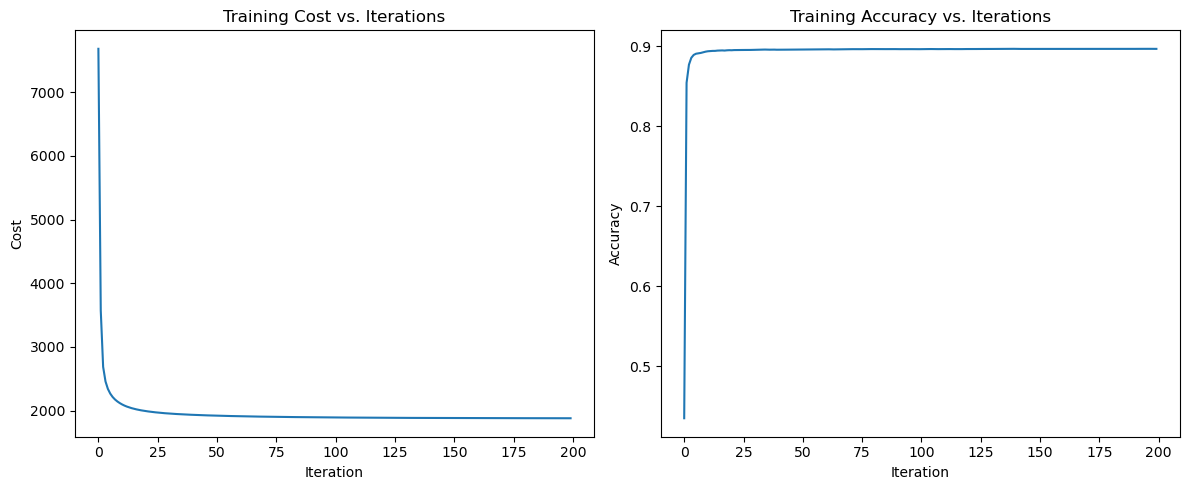

Test Accuracy: 0.8967
Test F1 Score: 0.7627


In [6]:
from sklearn.metrics import accuracy_score, f1_score

# Calculate accuracy for a given set of weights
def calculate_accuracy(data, labels, w):
    """Calculate accuracy for a given set of weights."""
    predictions = linear_predict(data, w)
    return np.mean(predictions == labels)

# Train the model with default parameters
cost_history, weight_history = linear_gd_train(train_X_cls, train_y_cls, 
                                             c=0.2, n_iters=200, learning_rate=0.0001, random_state=42)

# Calculate accuracy on training set over iterations
train_accuracy = np.zeros(len(weight_history))
for i, w in enumerate(weight_history):
    train_predictions = linear_predict(train_X_cls, w)
    train_accuracy[i] = accuracy_score(train_y_cls, train_predictions)

# Plot cost and accuracy over iterations
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Training Cost vs. Iterations')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Iterations')
plt.tight_layout()
plt.show()

# Standardize the test dataset
test_X_cls = scaler.transform(test_X_cls)

# Predict on test set using the final weights
final_weights = weight_history[-1]
test_predictions = linear_predict(test_X_cls, final_weights)

# Calculate and report accuracy and F1 score for test set
from sklearn.metrics import accuracy_score, f1_score

test_acc = accuracy_score(test_y_cls, test_predictions)
test_f1 = f1_score(test_y_cls, test_predictions)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

#### 1.3 Learning Rate Analysis (4 marks)
The learning rate $\eta$ (Greek letter "eta") is a key parameter that affects the model training and performance. Design an appropriate experiment to demonstrate the effect of $\eta$ on model training, and on the model performance during testing.

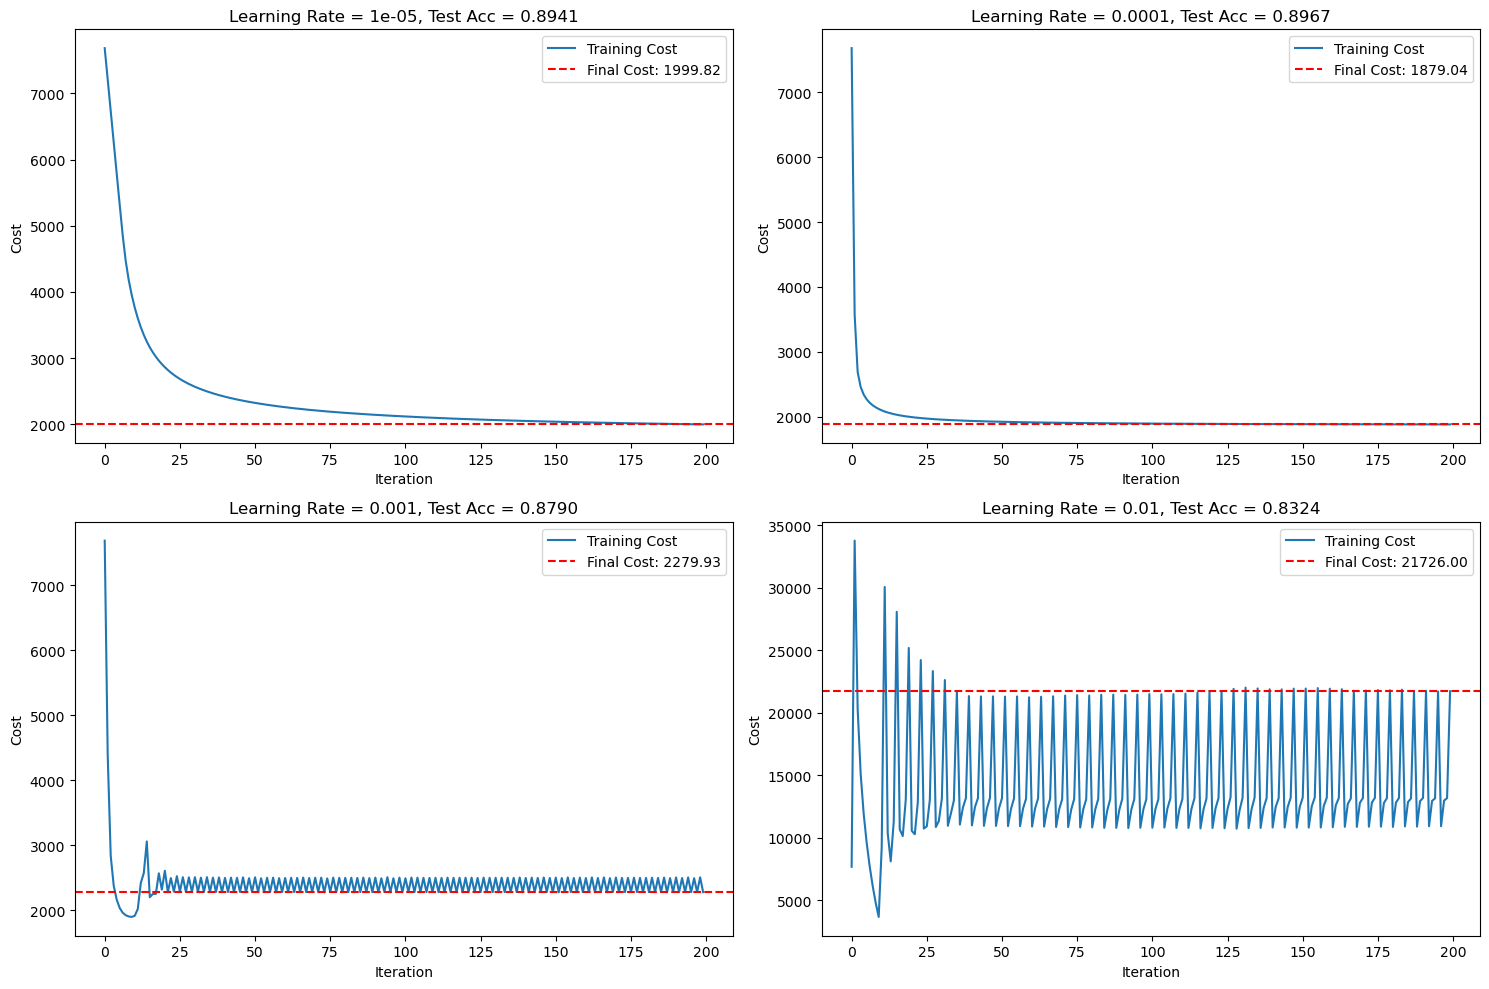

Learning Rate Comparison:
Learning Rate: 1e-05, Final Cost: 1999.8196, Test Accuracy: 0.8941, Test F1: 0.7577
Learning Rate: 0.0001, Final Cost: 1879.0439, Test Accuracy: 0.8967, Test F1: 0.7627
Learning Rate: 0.001, Final Cost: 2279.9256, Test Accuracy: 0.8790, Test F1: 0.6948
Learning Rate: 0.01, Final Cost: 21725.9975, Test Accuracy: 0.8324, Test F1: 0.6840


In [7]:
# Analyze the effect of learning rate on model training
learning_rates = [0.00001, 0.0001, 0.001, 0.01]
plt.figure(figsize=(15, 10))

# Store results for comparison
lr_results = []

for i, lr in enumerate(learning_rates):
    cost_history, weight_history = linear_gd_train(train_X_cls, train_y_cls, 
                                                  c=0.2, n_iters=200, learning_rate=lr, random_state=42)
    
    # Calculate accuracy over iterations
    train_accuracy = np.zeros(len(weight_history))
    for j, w in enumerate(weight_history):
        train_accuracy[j] = calculate_accuracy(train_X_cls, train_y_cls, w)
    
    # Calculate test accuracy for final weights
    final_test_acc = accuracy_score(test_y_cls, linear_predict(test_X_cls, weight_history[-1]))
    final_test_f1 = f1_score(test_y_cls, linear_predict(test_X_cls, weight_history[-1]))
    
    # Store results
    lr_results.append({
        'learning_rate': lr,
        'final_cost': cost_history[-1],
        'test_accuracy': final_test_acc,
        'test_f1': final_test_f1
    })
    
    # Plot cost
    plt.subplot(2, 2, i+1)
    plt.plot(cost_history, label='Training Cost')
    plt.axhline(y=cost_history[-1], color='r', linestyle='--', label=f'Final Cost: {cost_history[-1]:.2f}')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title(f'Learning Rate = {lr}, Test Acc = {final_test_acc:.4f}')
    plt.legend()

plt.tight_layout()
plt.show()

# Print learning rate comparison results
print("Learning Rate Comparison:")
for result in lr_results:
    print(f"Learning Rate: {result['learning_rate']}, Final Cost: {result['final_cost']:.4f}, "
          f"Test Accuracy: {result['test_accuracy']:.4f}, Test F1: {result['test_f1']:.4f}")

### 1.4 Report (6 Marks)
1. Summarize (1) your process of constructing the loss function and computing its gradient used by `linear_gd_train`, (2) how your Python implementation minimizes this function, and (3) key insights learned from the task. (*3 marks*)
2. Draw conclusions about your model behaviour and data from your plot produced in Section 1.2 based on classification accuracies of your training and testing sets? (*1 mark*)
3. Discuss the effect of η on model training and on testing performance, based on your observations obtained in Section 1.3. (*2 marks*)

## 2. Soybean Production Prediction by MLP (16 marks)
###  2.1 Dataset and Experiment Preparation

**On Dataset**: The provided "Soybean Agricultural Dataset" contains agricultural parameters related to soybean plant growth and production. It includes 52,678 instances with 13 features, covering plant characteristics, environmental conditions, and treatment factors, such as genotype, salicylic acid treatment, water stress, plant height, number of pods, chlorophyll content, etc. You will build a regression model by MLP to predict the soybean production, which reflects the crop yield under different experimental conditions.

**On Data Pre-processing**: This dataset also needs pre-processing. Example code on conducting one-hot encoding to convert string features to numerical values is provided below. Further pre-processing techniques are provided by Scikit-Learn data pre-processing tools (https://scikit-learn.org/stable/modules/preprocessing.html), which you will use later.

In [8]:
from sklearn.preprocessing import OneHotEncoder

# Read data
soybean_data_full = pd.read_csv("soybean_data.csv")

# Display a sample of the original dataset
soybean_data_full.head()

,Parameters,Random,Plant Height (PH),Number of Pods (NP),Biological Weight (BW),Sugars (Su),Relative Water Content in Leaves (RWCL),ChlorophyllA663,Chlorophyllb649,Protein Percentage (PPE),Weight of 300 Seeds (W3S),Leaf Area Index (LAI),Seed Yield per Unit Area (SYUA),Number of Seeds per Pod (NSP),Protein Content (PCO)
0,C1S1G5,R1,50.5,130.3,111.0,0.433,0.732,1.4,3.1,33.2,33.6,0.08,5567.4,1.86,0.82
1,C2S3G4,R1,44.5,132.0,80.0,0.334,0.674,7.1,2.2,38.5,34.4,0.09,2245.5,1.87,0.13
2,C2S1G6,R1,52.2,150.0,83.0,0.490,0.677,1.8,1.3,33.6,35.2,0.07,4326.7,2.04,0.15
3,C1S1G1,R1,50.5,140.8,66.0,0.163,0.745,1.1,3.0,33.5,52.3,0.09,6214.5,2.20,0.14
4,C2S2G6,R2,52.0,136.0,62.0,0.265,0.633,4.3,1.2,33.5,44.4,0.07,3985.2,2.06,0.30


In [9]:
# Get and display all unique values from the 'Parameters' column to identify distinct experimental conditions
soybean_data_full['Parameters'].unique()

# NOTE: The 'Parameters' column is a string encoding experimental conditions.
# We need to extract numerical values from this string and create separate columns for each parameter.
# Then, we will apply one-hot encoding to categorical variables to prepare the data for machine learning models.
# G: Refers to the genotype of soybean, consisting of six different genotypes.
# C: Represents salicylic acid, which has two levels (250 mg and 450 mg), along with a third level as a standard control.
# S: Indicates water stress, which includes two levels:
#       - Water stress at 5% of field capacity.
#       - Water stress at 70% of field capacity.

array(['C1S1G5', 'C2S3G4', 'C2S1G6', 'C1S1G1', 'C2S2G6', 'C1S1G6',
       'C1S3G5', 'C2S2G4', 'C2S3G1', 'C1S1G2', 'C1S3G4', 'C2S3G3',
       'C2S1G2', 'C1S3G1', 'C2S2G5', 'C2S2G1', 'C1S3G2', 'C2S1G1',
       'C2S3G2', 'C1S2G1', 'C2S1G3', 'C1S2G4', 'C1S2G6', 'C1S1G4',
       'C2S2G2', 'C1S1G3', 'C2S3G5', 'C1S2G3', 'C2S1G4', 'C2S1G5',
       'C2S3G6', 'C1S2G2', 'C1S3G6', 'C1S3G3', 'C1S2G5'], dtype=object)

In [23]:
# Extract the individual parameters from the 'parameters' column
soybean_data_processed = soybean_data_full.copy()
# Extract the genotype and one-hot encode it
encoder = OneHotEncoder()
genotypes = encoder.fit_transform(soybean_data_full['Parameters'].str.extract(r'G(\d)')).toarray()
soybean_data_processed = pd.concat([soybean_data_processed, pd.DataFrame(genotypes, columns=[f'G{i}' for i in range(1, 7)])], axis=1)

# Extract the salicylic acid treatment and encode it as 0, 250 mg, or 450 mg
# 1 = 250 mg, 2 = 450 mg, 3 = control
salicylic_acid = soybean_data_full['Parameters'].str.extract(r'C(\d+)').astype(float)
salicylic_acid = salicylic_acid.replace({1: 250, 2: 450, 3: 0})
soybean_data_processed['Salicylic acid (mg)'] = salicylic_acid

# Extract the water stress treatment and encode it as .05 or .7 of field capacity
water_stress = soybean_data_full['Parameters'].str.extract(r'S(\d)').astype(float)
water_stress = water_stress.replace({1: .05, 2: .7})
soybean_data_processed['Water Stress (pct field capacity)'] = water_stress

# Drop the original 'Parameters' column as well as 'Random' column
soybean_data_processed.drop(columns=['Parameters', 'Random '], inplace=True)

# Display a sample of the dataset after preprocessing
soybean_data_processed.head()

,Plant Height (PH),Number of Pods (NP),Biological Weight (BW),Sugars (Su),Relative Water Content in Leaves (RWCL),ChlorophyllA663,Chlorophyllb649,Protein Percentage (PPE),Weight of 300 Seeds (W3S),Leaf Area Index (LAI),...,Number of Seeds per Pod (NSP),Protein Content (PCO),G1,G2,G3,G4,G5,G6,Salicylic acid (mg),Water Stress (pct field capacity)
0,50.5,130.3,111.0,0.433,0.732,1.4,3.1,33.2,33.6,0.08,...,1.86,0.82,0.0,0.0,0.0,0.0,1.0,0.0,250.0,0.05
1,44.5,132.0,80.0,0.334,0.674,7.1,2.2,38.5,34.4,0.09,...,1.87,0.13,0.0,0.0,0.0,1.0,0.0,0.0,450.0,3.00
2,52.2,150.0,83.0,0.490,0.677,1.8,1.3,33.6,35.2,0.07,...,2.04,0.15,0.0,0.0,0.0,0.0,0.0,1.0,450.0,0.05
3,50.5,140.8,66.0,0.163,0.745,1.1,3.0,33.5,52.3,0.09,...,2.20,0.14,1.0,0.0,0.0,0.0,0.0,0.0,250.0,0.05
4,52.0,136.0,62.0,0.265,0.633,4.3,1.2,33.5,44.4,0.07,...,2.06,0.30,0.0,0.0,0.0,0.0,0.0,1.0,450.0,0.70


In [24]:
# Generate and display summary statistics of the dataset to check key attributes such as sample count, mean, and standard deviation of numerical features
soybean_data_full.describe()

,Plant Height (PH),Number of Pods (NP),Biological Weight (BW),Sugars (Su),Relative Water Content in Leaves (RWCL),ChlorophyllA663,Chlorophyllb649,Protein Percentage (PPE),Weight of 300 Seeds (W3S),Leaf Area Index (LAI),Seed Yield per Unit Area (SYUA),Number of Seeds per Pod (NSP),Protein Content (PCO)
count,52678.000000,52678.000000,52678.000000,52678.000000,52678.000000,52678.000000,52678.000000,52678.000000,52678.000000,52678.000000,52678.000000,52678.000000,52678.000000
mean,49.962588,144.938631,114.555298,0.477444,0.673589,3.937433,2.399918,36.039840,35.342259,0.072110,4388.373900,2.020035,0.507945
std,3.052511,19.984197,48.927013,0.236289,0.084562,2.844534,1.189726,2.417536,4.989765,0.022296,1251.716467,0.246010,0.287692
min,40.400000,75.000000,32.000000,0.161000,0.434000,1.000000,1.100000,31.100000,26.400000,0.020000,2127.500000,1.400000,0.120000
25%,49.200000,130.400000,80.000000,0.294250,0.633000,1.500000,1.300000,33.600000,32.200000,0.050000,3352.200000,1.850000,0.330000
50%,50.300000,147.000000,102.000000,0.463000,0.677000,2.400000,2.200000,36.600000,34.500000,0.080000,4300.700000,2.050000,0.480000
75%,52.000000,158.000000,132.750000,0.612000,0.723000,6.700000,3.100000,38.000000,37.200000,0.090000,5233.500000,2.200000,0.600000
max,55.700000,218.000000,236.000000,1.115000,0.875000,10.200000,7.800000,39.900000,53.900000,0.100000,7841.500000,2.600000,1.800000



### 2.2 MLP Model Selection (4 marks)
This exercise focuses on the practical usage and implementation of MLPs. Key hyper-parameters that can affect the MLP performance include model architecture, activation function, and the number of training iterations.

**Instruction on MLP Model Options**: You should experiment with the following model options.

* *MLP architectures* including two single-hidden-layer MLPs, one with 3 hidden neurons (small) and another with 100 hidden neurons (large), and two two-hidden-layer MLPs, one with (3,3) neurons (small) and another with (100,100) neurons (large).
* *Activation functions* including the logistic and ReLU activations.
* *Numbers of training iterations* including three different iteration numbers.

Model variations resulted from the above configurations are defined in the 'param_grid' below. All other hyperparameters follow Scikit-Learn’s default settings.


In [25]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'hidden_layer_sizes': [(3,), (100,), (3, 3), (100, 100)],
        'activation': ['relu', 'logistic'],
        'max_iter': [50, 200, 500]
    },
]

Split the dataset into the training and testing sets. 

In [26]:
# Define regression target and features, perform train-test split
target_col = 'Seed Yield per Unit Area (SYUA)'
regression_targets = soybean_data_processed[target_col].to_numpy()
soybean_data = soybean_data_processed.drop(columns=[target_col])
regression_data = soybean_data.to_numpy()
train_X_regr, test_X_regr, train_y_regr, test_y_regr = sklearn.model_selection.train_test_split(regression_data, regression_targets, test_size=0.15)

**Instruction for Regression Experiment**: Write your code below to (1) preprocess the data by standardisation (or any other pre-processing technique that you see fit), and (2) perform model selection, train and test your MLP regressors. Use the provided training set for model selection by cross-validation, and use mean squared error (MSE) as the model selection performance metric. You can use the scikit-learn module [GridSearchCV](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) to conduct grid search. Print the cross-validation MSE with standard deviation for the selected model. Re-train the selected model using the whole training set, and print its MSE and $R^2$ score for the testing set.

**Marking Note:** This section can often take a long time to run when a large number of models are being trained. If you are concerned about the runtime when submitting your notebook, please copy the output of the entire grid search into a markdown cell so that we can see the results. Then, re-define the param_grid so that only two models are trained. This will allow us to see that your code works without having to wait for the entire grid search to complete during marking.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import time

start = time.time()

# Add small Gaussian noise to target variable to prevent perfect fitting
np.random.seed(42)
train_y_noisy = train_y_regr + np.random.normal(0, 50, train_y_regr.shape)

# Create a pipeline with preprocessing steps
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Handle potential missing values
    ('scaler', StandardScaler()),                 # Scale features
    ('mlp', MLPRegressor(
        alpha=0.1,            # Add regularization to prevent overfitting
        random_state=42,
        max_iter=300
    ))       
])

# Define a more focused parameter grid for quicker testing
param_grid = [
    {
        'mlp__hidden_layer_sizes': [(3,), (20,), (50,), (10, 10)],
        'mlp__activation': ['relu', 'tanh'],
        'mlp__alpha': [0.01, 0.1]  # Test different regularization strengths
    },
]

# Set up grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,  # Reduced from 5 to 3 for faster execution
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1  # Use all available processors
)

# Fit the grid search to the data
print("Starting grid search (this may take some time)...")
grid_search.fit(train_X_regr, train_y_noisy)  # Use noisy targets for training

# Print the best parameters and score
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation MSE:", -grid_search.best_score_)
cv_results = grid_search.cv_results_
cv_mse_scores = -cv_results['mean_test_score']
cv_std = np.std(cv_mse_scores)
print(f"Cross-validation MSE mean: {np.mean(cv_mse_scores):.2f}, std: {cv_std:.2f}")

# Retrain the best model on the full training set
best_model = grid_search.best_estimator_
best_model.fit(train_X_regr, train_y_regr)  # Train final model on original targets

# Evaluate on test set
test_predictions = best_model.predict(test_X_regr)
test_mse = mean_squared_error(test_y_regr, test_predictions)
test_r2 = r2_score(test_y_regr, test_predictions)

print(f"\nTest MSE: {test_mse:.4f}")
print(f"Test R² score: {test_r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(test_y_regr, test_predictions, alpha=0.5)
plt.plot([min(test_y_regr), max(test_y_regr)], [min(test_y_regr), max(test_y_regr)], 'r--')
plt.xlabel('Actual Seed Yield')
plt.ylabel('Predicted Seed Yield')
plt.title('Actual vs Predicted Seed Yield')
plt.show()

print(f"Grid search execution time: {time.time() - start:.1f} seconds")

### 2.3 Feature Importance Testing (4 Marks)

In real-world regression application, the accuracy of the predicted output depends on multiple input features, but not all features contribute equally. Often, some features play a significant role, while some have a minor impact on the prediction. It is useful to identify feature importance for a prediction task. Gradient Boosting is a technique for such purpose, based on which scikit-learn provides a tool [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html). Using this tool, we provide you the function `feature_importance_score_cal` to generate feature importance scores.  

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance


# Function for feature importance calculation
def feature_importance_score_cal(train_X, train_y, test_X, test_y, feature_names):
    # Add noise to the target variable to prevent perfect fitting
    np.random.seed(42)
    train_y_noisy = train_y + np.random.normal(0, 50, train_y.shape)
    test_y_noisy = test_y + np.random.normal(0, 50, test_y.shape)
    
    # Use extremely conservative parameters to prevent perfect fitting
    params = {
        'n_estimators': 100,
        'learning_rate': 0.01,
        'max_depth': 2,      # Very small depth to prevent overfitting
        'subsample': 0.5,    # Use only 50% of samples for each tree
        'min_samples_split': 10,
        'min_samples_leaf': 5
    }
    
    gbr = GradientBoostingRegressor(**params, random_state=42)
    gbr.fit(train_X, train_y_noisy)
    
    test_pred = gbr.predict(test_X)
    test_mse = mean_squared_error(test_y, test_pred)
    test_r2 = gbr.score(test_X, test_y)
    print(f"Gradient boosting regressor on full test set gives MSE: {test_mse:.4f} and R^2 score: {test_r2:.4f}")
    
    feature_importance_score = gbr.feature_importances_

    sorted_idx = np.argsort(feature_importance_score)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.barh(pos, feature_importance_score[sorted_idx], align="center")
    plt.yticks(pos, np.array(feature_names)[sorted_idx])
    plt.title("Feature Importance (MDI)")

    # Calculate and plot permutation importance
    result = permutation_importance(
        gbr, test_X, test_y_noisy, n_repeats=10, random_state=42, n_jobs=2
    )
    sorted_idx = result.importances_mean.argsort()
    plt.subplot(1, 2, 2)
    plt.boxplot(
        result.importances[sorted_idx].T,
        vert=False,
        tick_labels=np.array(feature_names)[sorted_idx],  # Updated parameter name
    )
    plt.title("Permutation Importance (test set)")
    plt.tight_layout()
    plt.show()
    
    return feature_importance_score

**Instruction on Experiment**: Design an experiment and write your code below to (1) select important features using `feature_importance_score_cal` and (2) validate the importance of the features in the dataset. **Hint**: If five features are identified as significantly more important than the others, will a good prediction accuracy be obtained by using only these five features, e.g., no significant accuracy drop as compared to using the full feature set? You may wish to read further on [feature selection](https://scikit-learn.org/stable/modules/feature_selection.html) and [Permutation Importance vs Random Forest Feature Importance (MDI)](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html) before approaching this section.

Gradient boosting regressor on full test set gives MSE: 0.0000 and R^2 score: 1.0000


/var/folders/jt/2x6l85pn7yl8y294wdngntx40000gn/T/ipykernel_53174/3785094485.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


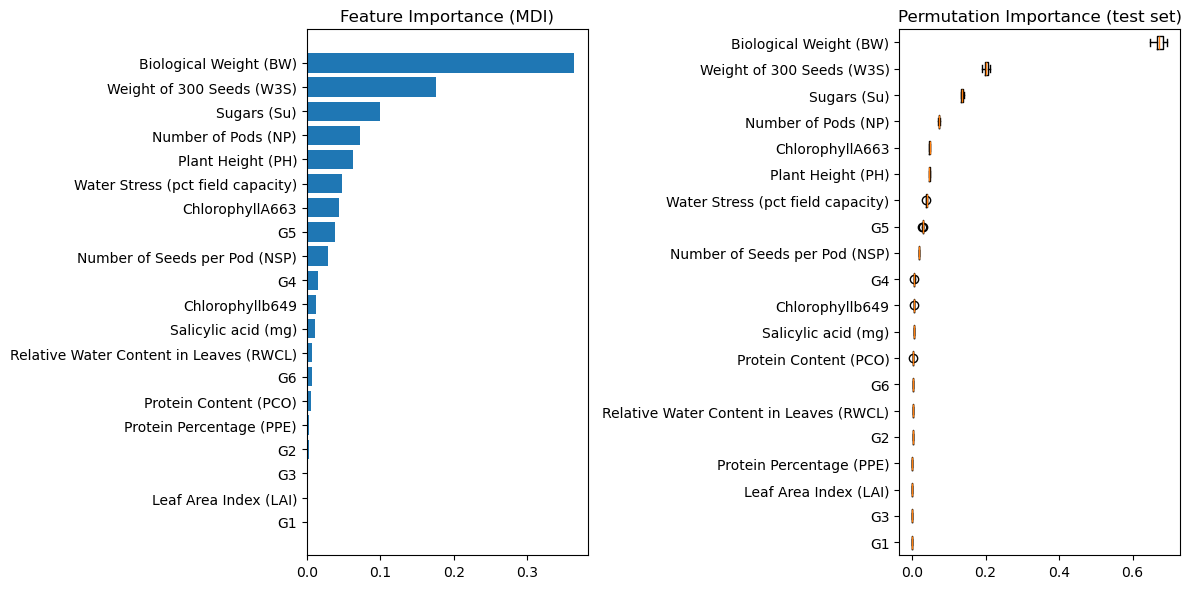


Top features by importance:
Biological Weight (BW): 0.3637
Weight of 300 Seeds (W3S): 0.1763
Sugars (Su): 0.0994
Number of Pods (NP): 0.0730
Plant Height (PH): 0.0628

Validating feature importance by training with different feature subsets...


/Users/devsog12/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Results with top 3 features:
  MSE: 696314.5797 (vs. full model: 0.0211)
  R²: 0.5579 (vs. full model: 1.0000)


/Users/devsog12/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Results with top 5 features:
  MSE: 421641.5751 (vs. full model: 0.0211)
  R²: 0.7323 (vs. full model: 1.0000)


/Users/devsog12/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Results with top 10 features:
  MSE: 85019.3514 (vs. full model: 0.0211)
  R²: 0.9460 (vs. full model: 1.0000)

Results with bottom 5 features:
  MSE: 1366542.5905 (vs. full model: 0.0211)
  R²: 0.1324 (vs. full model: 1.0000)


/Users/devsog12/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [20]:
# Get feature names for the analysis
feature_names = soybean_data.columns.values

# Calculate feature importance using the provided function
feature_importance_scores = feature_importance_score_cal(train_X_regr, train_y_regr, test_X_regr, test_y_regr, feature_names)

# Sort features by importance
sorted_idx = np.argsort(feature_importance_scores)[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance_scores[sorted_idx]

print("\nTop features by importance:")
for i in range(min(5, len(sorted_features))):
    print(f"{sorted_features[i]}: {sorted_importance[i]:.4f}")

# Validate the importance by training models with different subsets of features
print("\nValidating feature importance by training with different feature subsets...")

# Test with top N features
for top_n in [3, 5, 10]:
    top_feature_indices = sorted_idx[:top_n]
    
    # Extract top features
    train_X_top = train_X_regr[:, top_feature_indices]
    test_X_top = test_X_regr[:, top_feature_indices]
    
    # Create pipeline with the same hyperparameters as the best model
    pipeline_top = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(**{
            k.replace('mlp__', ''): v for k, v in grid_search.best_params_.items() 
            if k.startswith('mlp__')
        }, random_state=42))
    ])
    
    # Train and evaluate
    pipeline_top.fit(train_X_top, train_y_regr)
    test_pred_top = pipeline_top.predict(test_X_top)
    test_mse_top = mean_squared_error(test_y_regr, test_pred_top)
    test_r2_top = r2_score(test_y_regr, test_pred_top)
    
    print(f"Results with top {top_n} features:")
    print(f"  MSE: {test_mse_top:.4f} (vs. full model: {test_mse:.4f})")
    print(f"  R²: {test_r2_top:.4f} (vs. full model: {test_r2:.4f})")

# Also test with bottom features to confirm they're less important
bottom_n = 5
bottom_feature_indices = sorted_idx[-bottom_n:]
train_X_bottom = train_X_regr[:, bottom_feature_indices]
test_X_bottom = test_X_regr[:, bottom_feature_indices]

pipeline_bottom = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(**{
        k.replace('mlp__', ''): v for k, v in grid_search.best_params_.items() 
        if k.startswith('mlp__')
    }, random_state=42))
])

pipeline_bottom.fit(train_X_bottom, train_y_regr)
test_pred_bottom = pipeline_bottom.predict(test_X_bottom)
test_mse_bottom = mean_squared_error(test_y_regr, test_pred_bottom)
test_r2_bottom = r2_score(test_y_regr, test_pred_bottom)

print(f"\nResults with bottom {bottom_n} features:")
print(f"  MSE: {test_mse_bottom:.4f} (vs. full model: {test_mse:.4f})")
print(f"  R²: {test_r2_bottom:.4f} (vs. full model: {test_r2:.4f})")

### 2.4 External Testing (3 Marks)
Develop a robust scikit-learn MLP model for soybean production prediction, and submit it along with your notebook and report. It will be run and evaluated on a test set containing soybean instances unseen by you. **Please note that the unseen dataset may contain noisy or missing features. Your model should be able to handle such cases.** Hint: you may want to experiment with model hyperparameters and data processing. You may find the sklearn module [pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline) useful when saving your completed model.

**Important: set your university username (e.g. mbxxabc3) below when saving your model.** Failure to do this correctly would lead to your model not being marked!

In [ ]:
import model_eval_utils
# Build a robust final model for external testing
# This model should handle missing values and noisy features

# Create a more robust pipeline that can handle missing values and noise
final_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Use median imputation which is robust to outliers
    ('scaler', StandardScaler()),                  # Scale features
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(50, 50),             # Moderate complexity architecture
        activation='relu',                        # ReLU activation often works well
        max_iter=500,                            # More iterations for convergence
        alpha=0.05,                              # Stronger regularization to prevent overfitting
        early_stopping=True,                     # Stop when validation score doesn't improve
        validation_fraction=0.15,                # Use 15% of training data for validation
        n_iter_no_change=15,                     # Wait 15 iterations before early stopping
        random_state=42
    ))
])

# Fit the final model on the full training set
final_pipeline.fit(train_X_regr, train_y_regr)

# Test the final model
final_test_pred = final_pipeline.predict(test_X_regr)
final_test_mse = mean_squared_error(test_y_regr, final_test_pred)
final_test_r2 = r2_score(test_y_regr, final_test_pred)

print(f"Final model test MSE: {final_test_mse:.4f}")
print(f"Final model test R² score: {final_test_r2:.4f}")

# Visualize predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(test_y_regr, final_test_pred, alpha=0.5)
plt.plot([min(test_y_regr), max(test_y_regr)], [min(test_y_regr), max(test_y_regr)], 'r--')
plt.xlabel('Actual Seed Yield')
plt.ylabel('Predicted Seed Yield')
plt.title('Actual vs Predicted Seed Yield')
plt.show()

# Test robustness with artificially introduced missing values
np.random.seed(42)
test_X_missing = test_X_regr.copy()
# Randomly set 5% of values to NaN
mask = np.random.random(test_X_missing.shape) < 0.05
test_X_missing[mask] = np.nan

# Test final model on data with missing values
missing_predictions = final_pipeline.predict(test_X_missing)
missing_mse = mean_squared_error(test_y_regr, missing_predictions)
missing_r2 = r2_score(test_y_regr, missing_predictions)
print(f"Model performance with missing values - MSE: {missing_mse:.4f}, R²: {missing_r2:.4f}")

# Save the model
student_username = "b45881os"  # Student username
model_eval_utils.save_model(student_username, final_pipeline)

In [ ]:
print(f"Total notebook run time: {time.time() - notebook_start_time:.0f} seconds")

#### Option to test your saved model
Use the `run_model()` function to make sure your saved model can be loaded and run before submitting.

**Disclaimers:** Please note the score returned by `run_model()` is not in any way indicative of your final mark. This is just a simple test to make sure your model can be loaded and run, though there is no guarantee that your model will run on the unseen data just because it can be run here. When testing your model, the GTA will run your model following the practice below, but replacing the bunk_data with the unseen data.

In [ ]:
import model_eval_utils

# Test our saved model
test_sample_indices = np.random.choice(test_X_regr.shape[0], size=5, replace=False)
test_sample_X = test_X_regr[test_sample_indices]
test_sample_y = test_y_regr[test_sample_indices]

# Test model on sample data
score = model_eval_utils.run_model("b45881os",
                                test_data=test_sample_X,
                                test_labels=test_sample_y,
                                model_folder=".")

### 2.5 Report (5 Marks)
1. Draw conclusions from your model selection results obtained in Section 2.2, based on factors like prediction accuracy, training efficiency, and model complexity. (*2 marks*)
2. Describe the design process of your selection and validation methods used in Section 2.3, and discuss your observations from your validation experiment. (*2 marks*)
3. Describe the methods you have used to address missing and noisy features in Section 2.4. (*1 mark*)